# Lab 7-1. Autoencoder

### 이번 실습은 autoencoder 를 구현해보면서 Encoder-Decoder 구조에 대해 익혀보겠습니다.

### 먼저 MLP로 이루어진 autoencoder 를 구현해서 MNIST 에 적용시켜보도록 하겠습니다.

### 또한 CNN 기반의 autoencoder를 구현하면서 upsampling 방법도 익혀보도록 하겠습니다.





### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split


from torchvision import datasets, transforms


import matplotlib.pyplot as plt

## 7-1.1. MNIST Dataset prepare

### Data Prepare

In [3]:
# data 경로 설정 
# root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root = os.path.join(os.getcwd(), "drive", "MyDrive", "프로그래밍_교육", "쏘카 ai 엔지니어 육성 부트캠프 2기", "강의", "data")

# torchvision 이 제공하는 dataset 불러오기
# https://pytorch.org/vision/stable/datasets 에서 class argument 들 확인 가능
mnist_train = datasets.MNIST(
    root=root,                         # 데이터를 읽어오거나 다운로드 할 경로
    train=True,                        # Train data
    download=True,                     # 자동으로 root에서 읽어오기 / 혹은 없다면 다운로드
    transform=transforms.ToTensor()    # pytorch Tensor 형태의 data로 변환
)
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) 

### Train / Val Split

In [4]:
# MNIST DataLoader 생성
random_seed = 0
torch.manual_seed(random_seed)

val_size = int(len(mnist_train) * 0.1)
train_size = len(mnist_train) - val_size

mnist_train, mnist_valid = random_split(mnist_train, [train_size, val_size])
print(len(mnist_train), len(mnist_valid))

mnist_dataset = [mnist_train, mnist_valid, mnist_test]

# DataLoader 정의
mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)    # train 시에는 데이터를 shuffle 해줌
mnist_valid_loader = DataLoader(dataset=mnist_valid, batch_size=64, shuffle=False, drop_last=True)   
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

54000 6000


## 7-1.2. MLP Autoencoder

### Simple mlp autoencoder model

In [5]:
## mlp autoencoder 모델

class Lion_MNIST_MLP_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28),
            nn.Sigmoid()
        )
    

    
    def forward(self, x):
        latent_x = self.encoder(x)
        y = self.decoder(latent_x)
        y = y.view(-1,1, 28, 28)
        return y

In [6]:
sample_x = mnist_valid[0][0].unsqueeze(dim=0)    # unsqeeze : 데이터를 1차원 확장 --> dim 에 해당하는 차원으로
print(sample_x.shape)                            # CNN의 input 이 (batch, channels, H, W) 꼴이므로 맞춰주기 위해 (batch=1)로 차원을 확장

torch.Size([1, 1, 28, 28])


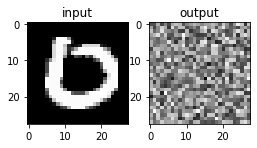

In [7]:
mlp_ae = Lion_MNIST_MLP_Autoencoder()
y = mlp_ae(sample_x)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sample_x.squeeze(), cmap='gray')
ax.title.set_text("input")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y.detach().squeeze(), cmap='gray')
ax.title.set_text("output")
fig.show()

In [9]:
y.detach().shape

torch.Size([1, 1, 28, 28])

In [10]:
y.detach().squeeze().shape

torch.Size([28, 28])

### Training MLP autoencoder

In [11]:
## Trainer class 정의

class Autoencoder_Trainer(nn.Module):
    def __init__(self, model, dataset, opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
        """
          Args:
            model: 사용할 model
            dataset: 사용할 dataset [train, valid, test]
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.MSELoss()                      # loss function 정의

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device
        self.train_data = dataset[0]                  # 사용할 데이터들을 class 안에 정리
        self.valid_data = dataset[1]
        self.test_data = dataset[2]

    def _get_optimizer(self, opt, lr=0.001):
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
    #     self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()

            if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val()   # 현재 model에 대한 결과 이미지 plot 
                start_time = time.time()   

        self.plot_history(history)       # 그래프 출력

    def _train_epoch(self, train_loader):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        for (x, y) in train_loader:        # x: data, y:label

            x = x.to(self.device)

            x_hat = self.model(x)            # model이 복원한 input x 
            loss = self.loss(x_hat, x)       

            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                x = x.to(self.device)

                x_hat = self.model(x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

        fig.show()

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                x = x.to(self.device)

                x_hat = self.model(x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()     # 결과 이미지 plot
    
    def vis_train_val(self):
        """
          현재 model에서 train, vallid data 에 대한 결과를 visualize
        """
        fig = plt.figure(figsize=(4,4))
        for i in range(4):
            img = self.train_data[i][0]
            ax = fig.add_subplot(4, 4, i*4+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_train")

            img = self.model(self.train_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 4, i*4+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_train")

            img = self.valid_data[i][0]
            ax = fig.add_subplot(4, 4, i*4+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_valid")

            img = self.model(self.valid_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 4, i*4+4)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_valid")
        plt.show()
        
    def vis_test(self):
        """
          현재 model에서 test data 에 대한 결과를 visualize
        """
        fig = plt.figure(figsize=(4,4))
        for i in range(4):
            img = self.test_data[i][0]
            ax = fig.add_subplot(4, 2, i*2+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_test")

            img = self.model(self.test_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 2, i*2+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_test")

        plt.show()

===== Train Start =====
Epoch: 0, train loss: 0.051325, valid loss: 0.030721, time: 6.455445


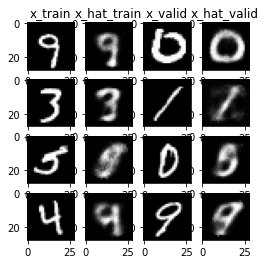

Epoch: 1, train loss: 0.025023, valid loss: 0.021754, time: 6.199296


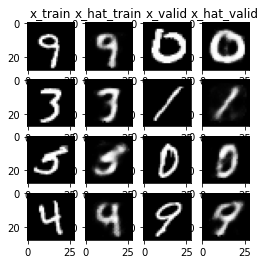

Epoch: 2, train loss: 0.019709, valid loss: 0.018384, time: 6.097266


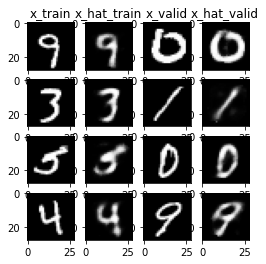

Epoch: 3, train loss: 0.017423, valid loss: 0.016673, time: 6.214794


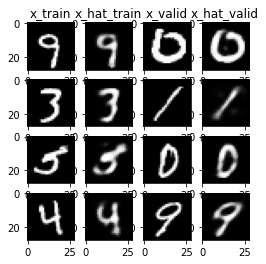

Epoch: 4, train loss: 0.016054, valid loss: 0.015536, time: 7.207450


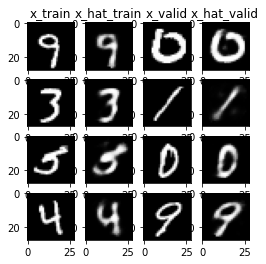

Epoch: 5, train loss: 0.015006, valid loss: 0.014622, time: 6.132130


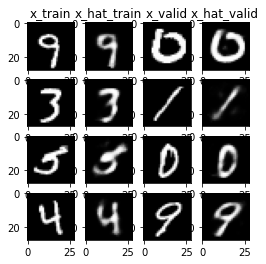

Epoch: 6, train loss: 0.014160, valid loss: 0.013825, time: 6.276223


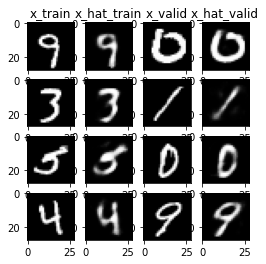

Epoch: 7, train loss: 0.013471, valid loss: 0.013328, time: 6.279348


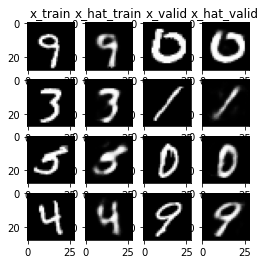

Epoch: 8, train loss: 0.012946, valid loss: 0.012856, time: 6.172006


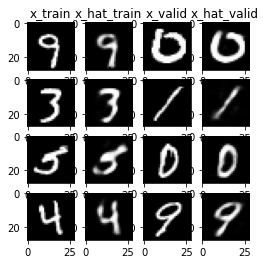

Epoch: 9, train loss: 0.012615, valid loss: 0.012878, time: 6.228269


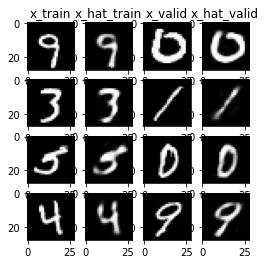

Training time : 74.940546
===== Test Start =====
Test loss: 0.012395, time: 0.906609


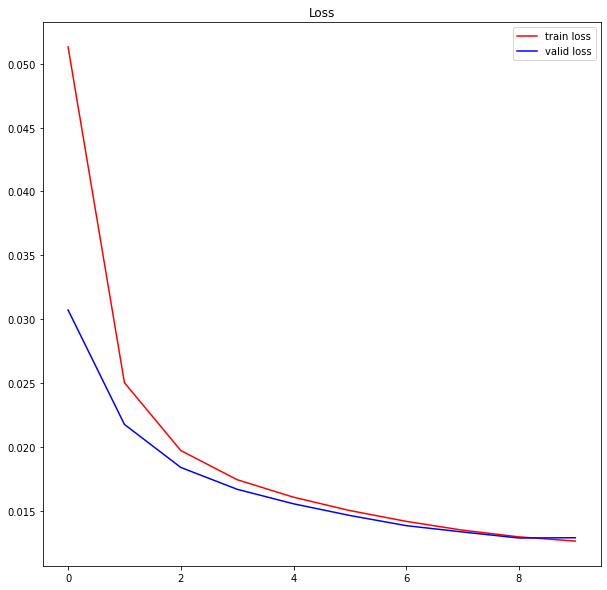

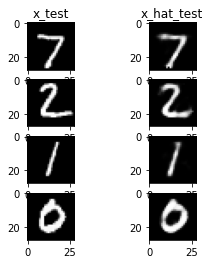

In [12]:
device = "cuda"
mlp_ae = Lion_MNIST_MLP_Autoencoder()
trainer = Autoencoder_Trainer(model=mlp_ae, dataset=mnist_dataset,
                              opt="adam", lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(mnist_train_loader, mnist_valid_loader, max_epochs=10, disp_epoch=1, visualize=True)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)

### Random noise

In [13]:
def add_noise(data, mean=0., std=0.1):
    """
        data 에 Gaussian noise 를 더해줌
        data: Tensor 
        mean: noise 의 평균
        std: noise의 표준편차
    """
    random_noise = torch.randn(data.size()) * std + mean    # torch.randn : (0,1) 사이 random 값을 생성
    return data + random_noise

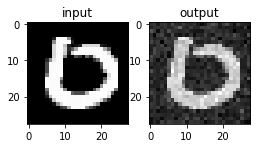

In [17]:
# 노이즈를 넣은 데이터 비교

sample_x = mnist_valid[0][0].unsqueeze(dim=0) 
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sample_x.squeeze(), cmap='gray')
ax.title.set_text("input")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(add_noise(sample_x, std=0.1).squeeze(), cmap='gray') # std(표준편차) 값이 커지면 노이즈가 심해진다.
ax.title.set_text("output")
fig.show()

In [18]:
## Noise 있는 autoencoder 에 대한 Trainer class 정의

class Noisy_Autoencoder_Trainer(nn.Module):
    def __init__(self, model, dataset, opt="adam", lr=0.001, has_scheduler=False, device="cpu", noise_mean=0., noise_std=0.1):
        """
          Args:
            model: 사용할 model
            dataset: 사용할 dataset [train, valid, test]
            opt: optimizer
            lr: learning rate
            has_scheduler: learning rate scheduler 사용 여부
            device: 사용할 device (cpu/cuda)
            noise_mean: noise 의 평균
            noise_std: noise의 표준편차
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.MSELoss()                      # loss function 정의

        self._get_optimizer(opt=opt.lower(), lr=lr)   # optimizer 정의
        self.has_scheduler = has_scheduler            # scheduler 사용여부 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device                          # 사용할 device
        self.train_data = dataset[0]                  # 사용할 데이터들을 class 안에 정리
        self.valid_data = dataset[1]
        self.test_data = dataset[2]
        
        self.noise_mean = noise_mean                  # noise에 대한 mean std
        self.noise_std = noise_std

    def _get_optimizer(self, opt, lr=0.001):
        """
          Args:
            opt: optimizer
            lr: learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
    #     self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
          네트워크를 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
            valid_loader: validation에 사용할 dataloader
            max_epochs: 학습을 진행할 총 epoch 수
            disp_epochs: 학습 log를 display 할 epoch 주기
            visualize: 학습 진행 과정에서 결과 이미지를 visualize 
        """
        print("===== Train Start =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)      # 현재 epoch에서 성능을 history dict에 저장
            history["valid_loss"].append(valid_loss)      #

            if self.has_scheduler:         # scheduler 사용할 경우 step size 조절
                self.scheduler.step()

            if e % disp_epoch == 0:        # disp_epoch 마다 결과값 출력 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val()   # 현재 model에 대한 결과 이미지 plot 
                start_time = time.time()   

        self.plot_history(history)       # 그래프 출력

    def _train_epoch(self, train_loader):
        """
          model를 training set 한 epoch 만큼 학습시키는 함수
          Args:
            train_loader: 학습에 사용할 train dataloader
          Returns:
            training set 한 epoch의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.train()                 # self.model을 train 모드로 전환 --> nn.Module의 내장함수
        for (x, y) in train_loader:        # x: data, y:label
            
            x = x.to(self.device)
            noisy_x = self.add_noise(x, self.device)    # 이미지에 noise 추가

            x_hat = self.model(noisy_x)     # noisy 한 input으로 model이 복원한 input x 
            loss = self.loss(x_hat, x)      # 학습 target 은 noise 없는 데이터가 되도록

            self.optimizer.zero_grad()       # backwardpass를 통한 network parameter 업데이트
            loss.backward()                  # 
            self.optimizer.step()            # 
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
          현재 model의 성능을 validation set에서 측정하는 함수
          Args:
            valid_loader: 학습에 사용할 valid dataloader
          Returns:
            validation set 의 평균 loss, 평균 accuracy
        """
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in valid_loader:
                x = x.to(self.device)
                noisy_x = self.add_noise(x, self.device)

                x_hat = self.model(noisy_x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
          history에 저장된 model의 성능을 graph로 plot
          Args:
            history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
                     각 item 들은 epoch 단위의 성능 history의 list
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

        fig.show()

    def test(self, test_loader):
        """
          현재 model의 성능을 test set에서 측정하는 함수
          Args:
            test_loader: 학습에 사용할 test dataloader
          Returns:
            test set 의 평균 loss, 평균 accuracy
        """
        print("===== Test Start =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                x = x.to(self.device)
                noisy_x = self.add_noise(x, self.device)

                x_hat = self.model(noisy_x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()     # 결과 이미지 plot
    
    def vis_train_val(self):
        """
          현재 model에서 train, vallid data 에 대한 결과를 visualize
        """
        fig = plt.figure(figsize=(9,6))
        for i in range(4):
            img = self.train_data[i][0]
            ax = fig.add_subplot(4, 6, i*6+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_train")
            
            img = self.add_noise(self.train_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 6, i*6+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_train")

            img = self.model(self.train_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 6, i*6+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_train")

            img = self.valid_data[i][0]
            ax = fig.add_subplot(4, 6, i*6+4)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("y_valid")
                
            img = self.add_noise(self.valid_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 6, i*6+5)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_valid")

            img = self.model(self.valid_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 6, i*6+6)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_valid")
        plt.show()
        
    def vis_test(self):
        """
          현재 model에서 test data 에 대한 결과를 visualize
        """
        fig = plt.figure(figsize=(9,6))
        for i in range(4):
            img = self.test_data[i][0]
            ax = fig.add_subplot(4, 3, i*3+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_test")
                
            img = self.add_noise(self.test_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 3, i*3+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_test")

            img = self.model(self.test_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 3, i*3+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_test")

        plt.show()
        
    def add_noise(self, data, device):
        """
            data 에 Gaussian noise 를 더해줌
            data: Tensor 
            device: 사용할 device (cpu/cuda)
        """
        random_noise = torch.randn(data.size()).to(device) * self.noise_std + self.noise_mean    # torch.randn : (0,1) 사이 random 값을 생성
        return data + random_noise

===== Train Start =====
Epoch: 0, train loss: 0.042303, valid loss: 0.035756, time: 6.537381


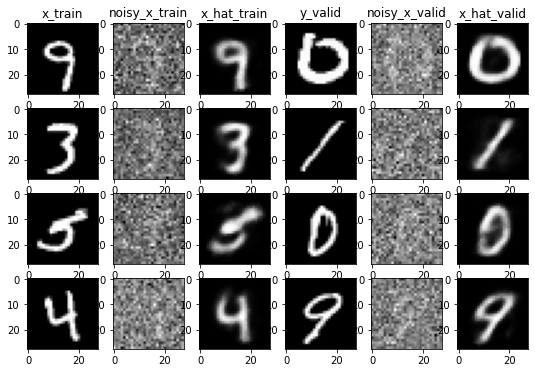

Epoch: 1, train loss: 0.034421, valid loss: 0.033679, time: 6.567402


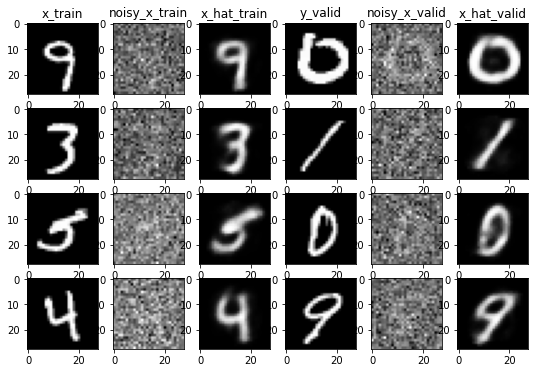

Epoch: 2, train loss: 0.033091, valid loss: 0.032832, time: 6.767426


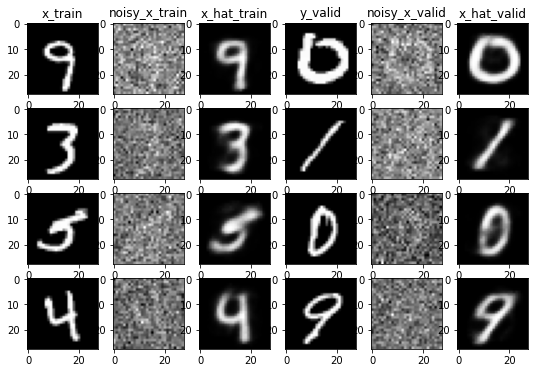

Epoch: 3, train loss: 0.032256, valid loss: 0.032206, time: 6.843202


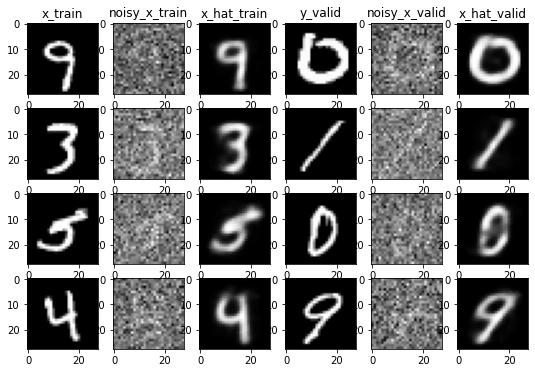

Epoch: 4, train loss: 0.031794, valid loss: 0.031648, time: 6.546970


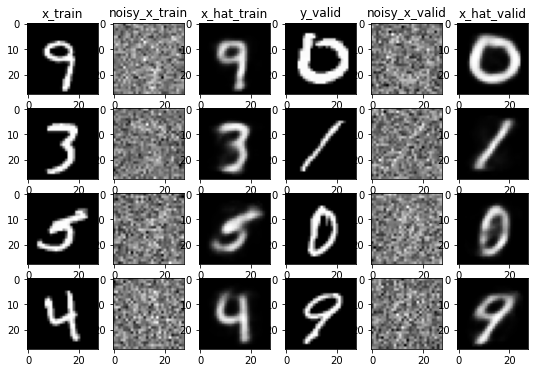

Epoch: 5, train loss: 0.031339, valid loss: 0.031220, time: 6.601485


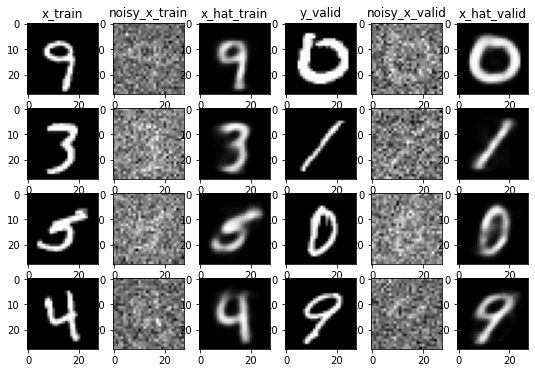

Epoch: 6, train loss: 0.031069, valid loss: 0.031123, time: 6.498689


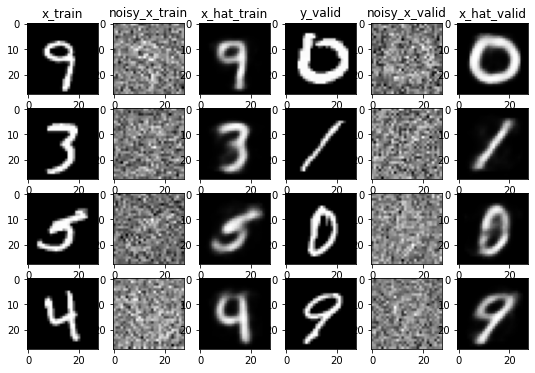

Epoch: 7, train loss: 0.030772, valid loss: 0.030747, time: 6.787574


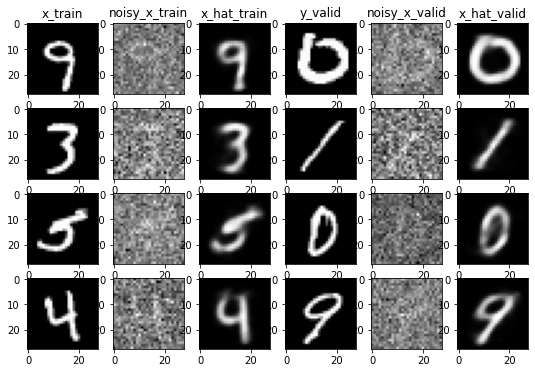

Epoch: 8, train loss: 0.030570, valid loss: 0.030523, time: 6.757552


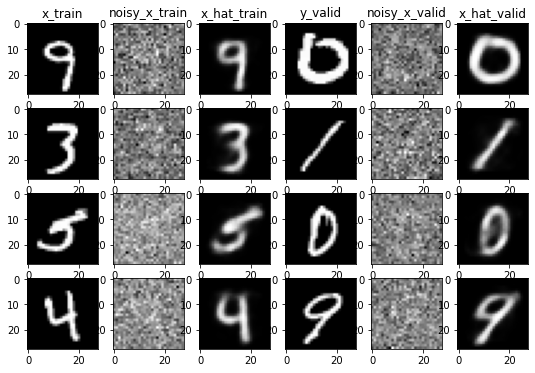

Epoch: 9, train loss: 0.030377, valid loss: 0.030588, time: 6.727054


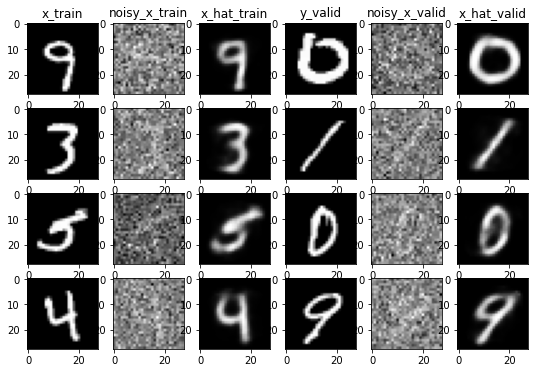

Training time : 84.668745
===== Test Start =====
Test loss: 0.030020, time: 0.884211


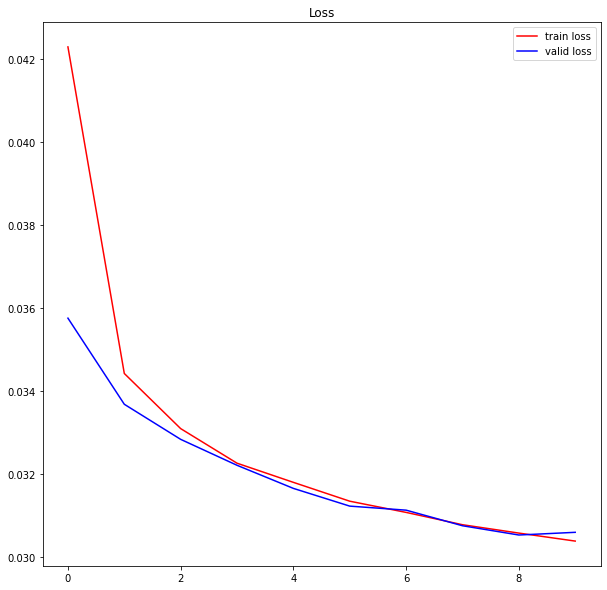

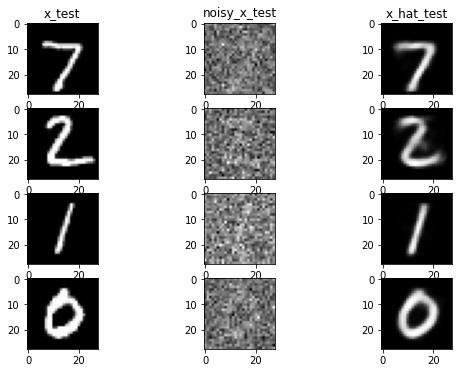

In [19]:
device = "cuda"
noisy_mlp_ae = Lion_MNIST_MLP_Autoencoder()                              
trainer = Noisy_Autoencoder_Trainer(model=mlp_ae, dataset=mnist_dataset,
                              opt="adam", lr=0.001, has_scheduler=False, device=device, noise_std=1.0).to(device)
start_time = time.time()
trainer.train(mnist_train_loader, mnist_valid_loader, max_epochs=10, disp_epoch=1, visualize=True)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)

## 7-1.3. CNN Autoencoder

In [20]:
## transposed convolution을 이용한 CNN autoencoder 모델

class Lion_MNIST_CNN_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),   # [batch, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                # [batch, 16, 14, 14]
            nn.Conv2d(16, 32, 3, stride=1, padding=1),                                       # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),                                            # [batch, 32, 7, 7]
        )
        
        # transposed convolution output size = (𝑑_𝑖𝑛−1)×𝑠𝑡𝑟𝑖𝑑𝑒+1−2×𝑝𝑎𝑑+𝑑𝑖𝑙𝑎𝑡𝑖𝑜𝑛×(𝑘−1) + output_pad
        # nn.ConvTransposed2d https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
            
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),    # [batch, 16, 14, 14]
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 2, stride=2),                                          # [batch, 1, 28, 28]
#             nn.Sigmoid()
#         )

    
    def forward(self, x, visualize_filter=False):
        latent_x = self.encoder(x)
        
        deconv1 = self.deconv1(latent_x)
        _deconv1 = self.relu(deconv1)
        deconv2 = self.deconv2(_deconv1)
        y = self.sigmoid(deconv2)        
        
        #         y = self.decoder(latent_x)
        
        if not visualize_filter:
            return y
        else:
            return deconv1, y

In [21]:
cnn_ae = Lion_MNIST_CNN_Autoencoder()

In [22]:
sample_x = mnist_valid[0][0].unsqueeze(dim=0)  
deconv1, y = cnn_ae(sample_x, visualize_filter=True)
print(deconv1.shape, y.shape)

torch.Size([1, 16, 14, 14]) torch.Size([1, 1, 28, 28])


===== Train Start =====
Epoch: 0, train loss: 0.058013, valid loss: 0.039310, time: 7.717263


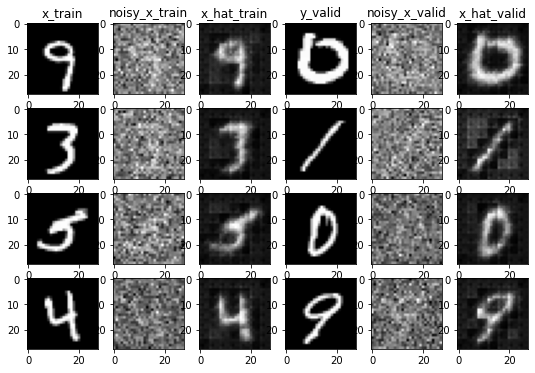

Epoch: 1, train loss: 0.038234, valid loss: 0.037760, time: 7.196079


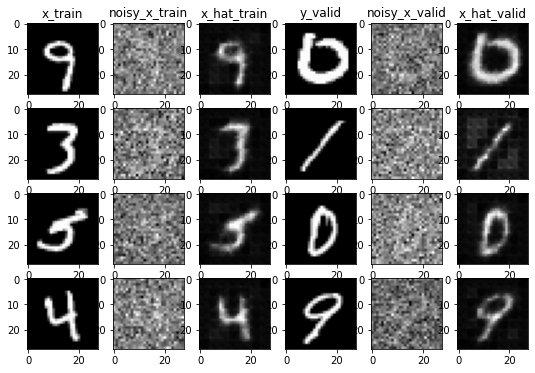

Epoch: 2, train loss: 0.037231, valid loss: 0.036953, time: 7.188408


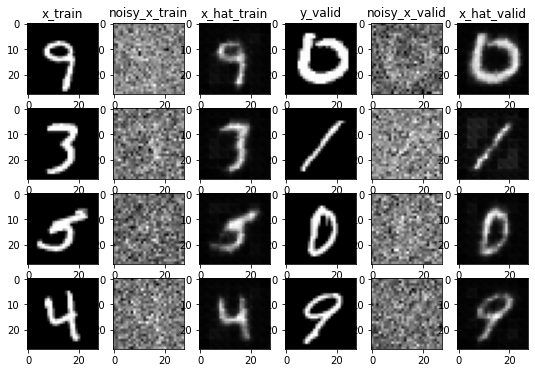

Epoch: 3, train loss: 0.036772, valid loss: 0.036719, time: 7.288569


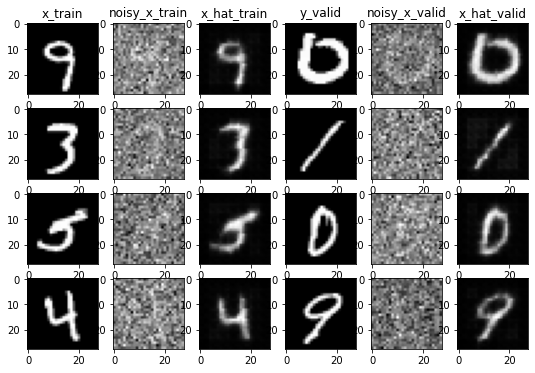

Epoch: 4, train loss: 0.036324, valid loss: 0.036282, time: 7.297906


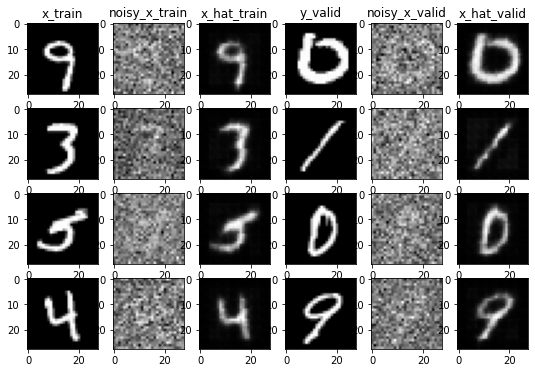

Epoch: 5, train loss: 0.036046, valid loss: 0.036016, time: 7.226537


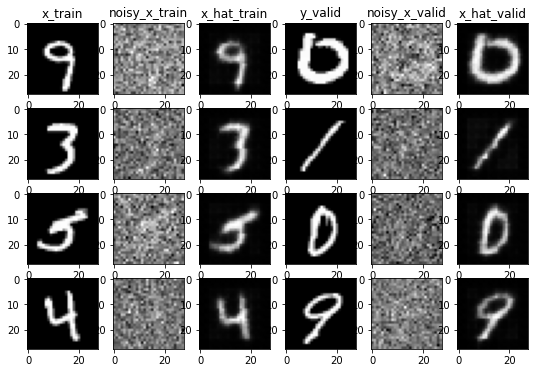

Epoch: 6, train loss: 0.035807, valid loss: 0.035858, time: 7.087147


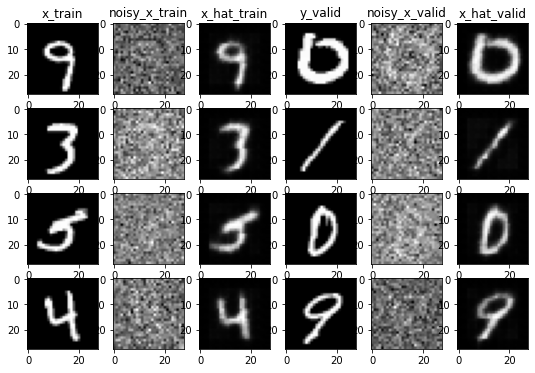

Epoch: 7, train loss: 0.035692, valid loss: 0.035785, time: 7.363139


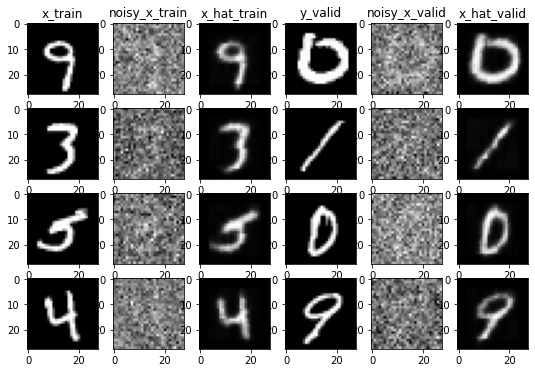

Epoch: 8, train loss: 0.035545, valid loss: 0.035771, time: 7.300137


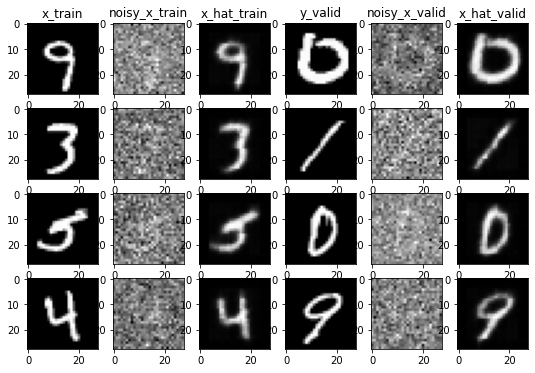

Epoch: 9, train loss: 0.035427, valid loss: 0.035493, time: 7.247832


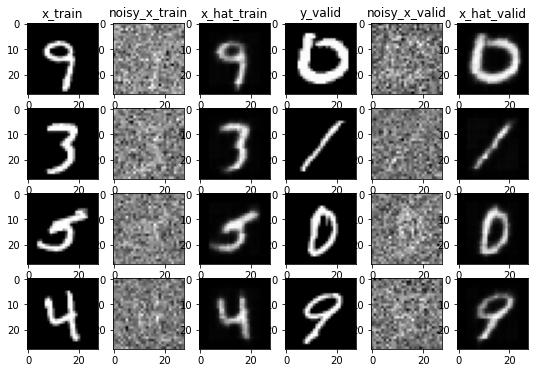

Training time : 90.911784
===== Test Start =====
Test loss: 0.035333, time: 0.944340


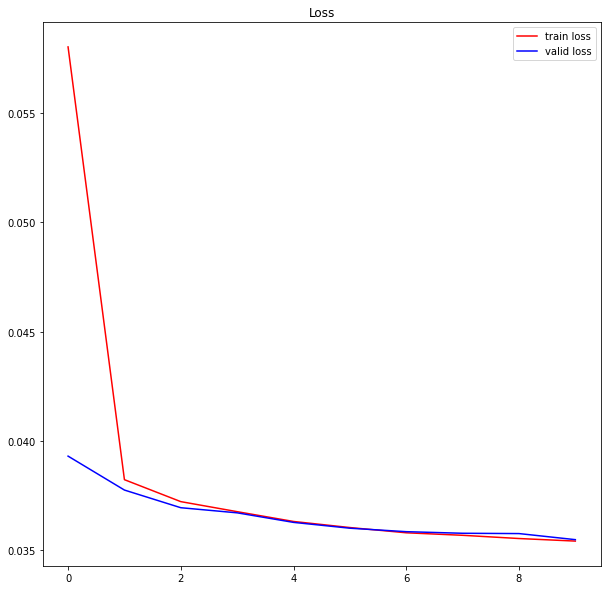

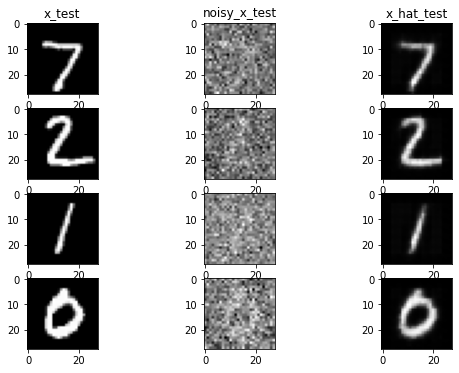

In [23]:
device = "cuda"   
trainer = Noisy_Autoencoder_Trainer(model=cnn_ae, dataset=mnist_dataset,
                              opt="adam", lr=0.001, has_scheduler=False, device=device, noise_std=1.0).to(device)
start_time = time.time()
trainer.train(mnist_train_loader, mnist_valid_loader, max_epochs=10, disp_epoch=1, visualize=True)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)

In [24]:
# biliear upsampling 을 활용한 CNN autoencoder 모델

class Lion_MNIST_CNN_Autoencoder_bilinear(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),   # [batch, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                # [batch, 16, 14, 14]
            nn.Conv2d(16, 32, 3, stride=1, padding=1),                                       # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),                                            # [batch, 32, 7, 7]
        )
        
        # nn.Upsample https://pytorch.org/docs/stable/generated/torch.nn.Upsample
            
#         self.decoder = nn.Sequential(
#             nn.Conv2d(32, 16, 3, stride=1, padding=1),                     # [batch, 32, 7, 7]
#             nn.Sigmoid(),
#             nn.Upsample(size=14, mode='bilinear'),                         # [batch, 32, 14, 14]
#             nn.Conv2d(16, 16, 3, stride=1, padding=1),                     # [batch, 16, 14, 14]
#             nn.Sigmoid(),
#             nn.Upsample(size=28, mode='bilinear'),                         # [batch, 16, 28, 28]
#             nn.Conv2d(16, 1, 3, stride=1, padding=1),                      # [batch, 1, 28, 28]
#             nn.Sigmoid()
#         )
        

        self.conv1 = nn.Conv2d(32, 16, 3, stride=1, padding=1)                     
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 1, 3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(size=14, mode='bilinear')
        self.upsample2 = nn.Upsample(size=28, mode='bilinear')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x, visualize_filter=False):
        latent_x = self.encoder(x)
        
        conv1 = self.sigmoid(self.conv1(latent_x))
        up1 = self.upsample1(conv1)
        conv2 = self.sigmoid(self.conv2(up1))
        up2 = self.upsample2(conv2)
        y = self.sigmoid(self.conv3(up2))
        
#         y = self.decoder(latent_x)
        if not visualize_filter:
            return y
        else:
            return conv1, up1, conv2, up2, y

torch.Size([1, 1, 28, 28])
torch.Size([1, 16, 14, 14]) torch.Size([1, 1, 28, 28])


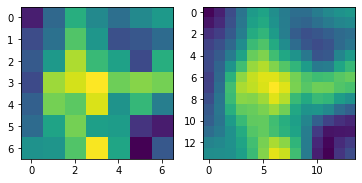

In [25]:
cnn_ae_bi = Lion_MNIST_CNN_Autoencoder_bilinear()
sample_x = mnist_valid[0][0].unsqueeze(dim=0)  
print(sample_x.shape)

conv1, up1, conv2, up2, y = cnn_ae_bi(sample_x, visualize_filter=True)
print(deconv1.shape, y.shape)

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(conv1.detach()[0][0])
ax = fig.add_subplot(1,2,2)
ax.imshow(up1.detach()[0][0])




===== Train Start =====
Epoch: 0, train loss: 0.055764, valid loss: 0.041108, time: 8.765601


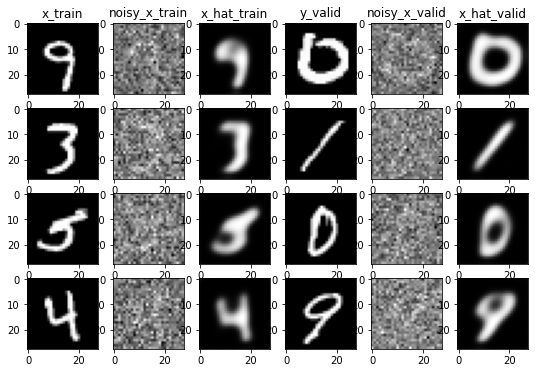

Epoch: 1, train loss: 0.038375, valid loss: 0.036619, time: 8.386588


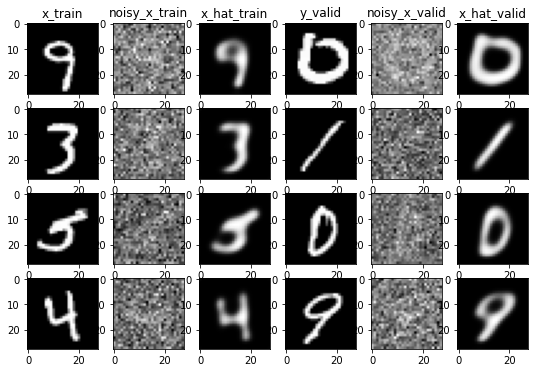

Epoch: 2, train loss: 0.035788, valid loss: 0.035319, time: 9.127060


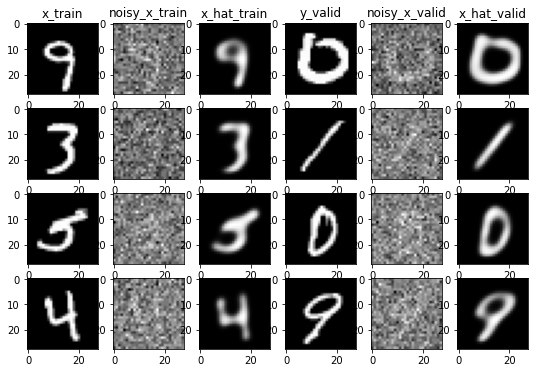

Epoch: 3, train loss: 0.034651, valid loss: 0.034204, time: 8.568102


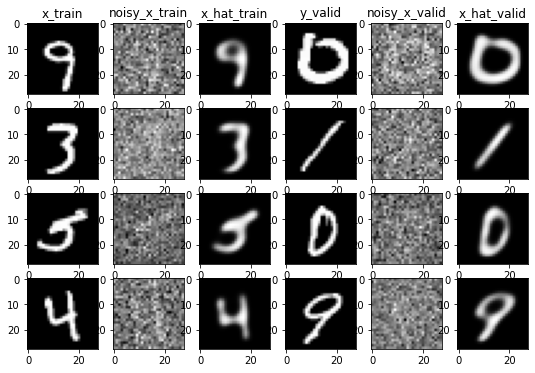

Epoch: 4, train loss: 0.033833, valid loss: 0.033630, time: 8.449589


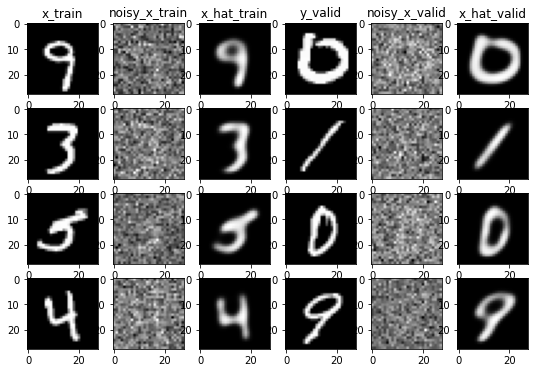

Epoch: 5, train loss: 0.033305, valid loss: 0.033202, time: 8.477452


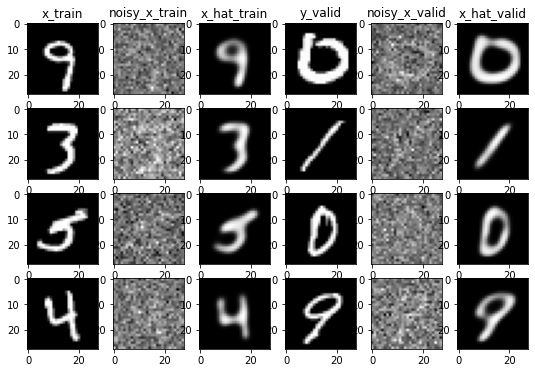

Epoch: 6, train loss: 0.032868, valid loss: 0.032877, time: 8.511743


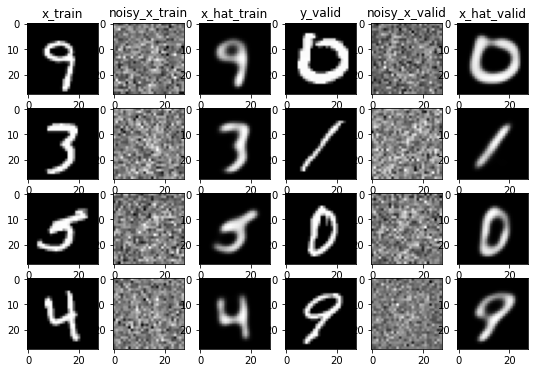

Epoch: 7, train loss: 0.032598, valid loss: 0.032496, time: 8.508957


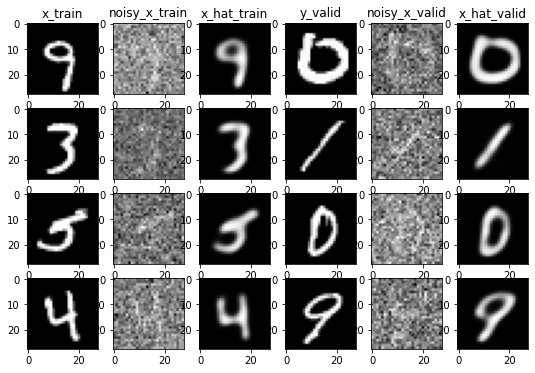

Epoch: 8, train loss: 0.032271, valid loss: 0.032144, time: 8.480882


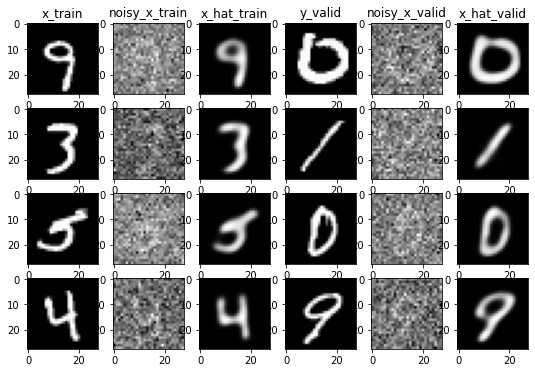

Epoch: 9, train loss: 0.032048, valid loss: 0.032202, time: 8.685060


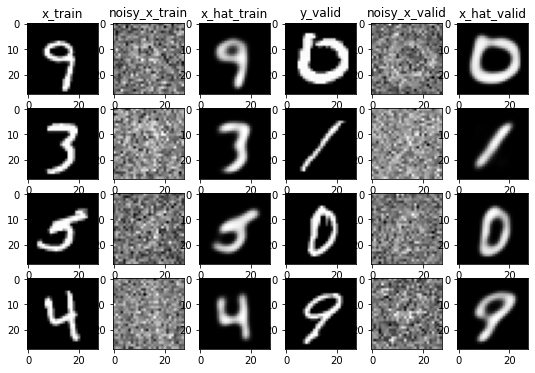

Training time : 104.377502
===== Test Start =====
Test loss: 0.031974, time: 1.093299


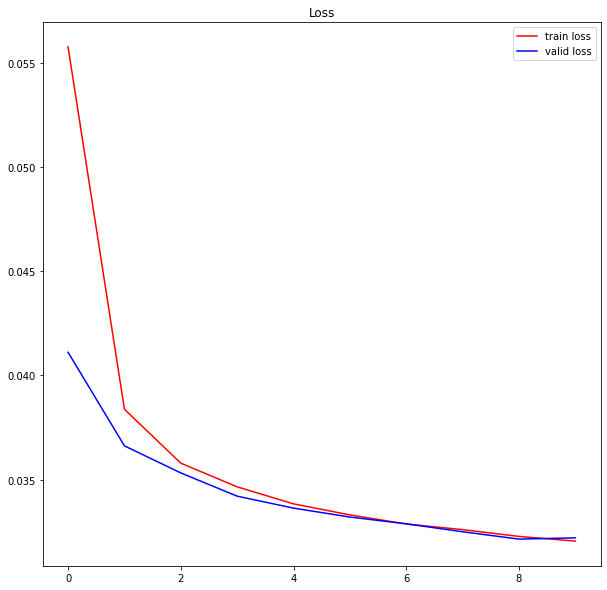

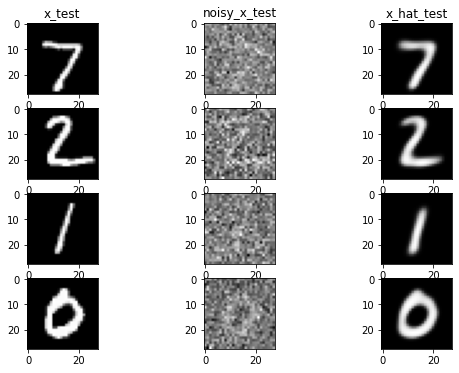

In [26]:
device = "cuda"   
cnn_ae_bi = Lion_MNIST_CNN_Autoencoder_bilinear()
trainer = Noisy_Autoencoder_Trainer(model=cnn_ae_bi, dataset=mnist_dataset,
                              opt="adam", lr=0.001, has_scheduler=False, device=device, noise_std=1.0).to(device)
start_time = time.time()
trainer.train(mnist_train_loader, mnist_valid_loader, max_epochs=10, disp_epoch=1, visualize=True)
print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)